<a href="https://colab.research.google.com/github/fadil-21/voiceAssistant/blob/master/chest_xray_pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 📦

In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! kaggle datasets download wilhelmberghammer/chest-xrays-pneumonia-detection

 99% 1.01G/1.02G [00:31<00:00, 40.8MB/s]
100% 1.02G/1.02G [00:31<00:00, 34.4MB/s]


In [9]:
import os
import zipfile

import cv2
import numpy as np
import pandas as pd
from numba import jit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare Data 📂
* **Load data**
    * preprocessing
    * augmentation
* **Create Dataloader**

In [10]:
# load dataset from drive into the instance -> it seems to be faster that way
! unzip chest-xrays-pneumonia-detection.zip

Archive:  chest-xrays-pneumonia-detection.zip
  inflating: data/test/BAC_PNEUMONIA/person100_bacteria_475.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person100_bacteria_477.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person100_bacteria_478.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person100_bacteria_479.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person100_bacteria_480.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person100_bacteria_481.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person101_bacteria_483.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person101_bacteria_484.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person101_bacteria_485.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person101_bacteria_486.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person102_bacteria_487.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person103_bacteria_488.jpeg  
  inflating: data/test/BAC_PNEUMONIA/person103_bacteria_489.jpeg  
  inflating: dat

In [11]:
def target_to_oh(target):
    NUM_CLASS = 3  # hard code here, can do partial
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot

In [12]:
train_data_path = "data/train"
test_data_path = "data/test"
BATCH_SIZE = 16

train_transforms = transforms.Compose([
                            transforms.Resize((150, 150)),
                            transforms.Grayscale(),
                            transforms.ToTensor(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.RandomRotation(45)
                            ])

test_transforms = transforms.Compose([
                            transforms.Resize((150,150)),
                            transforms.Grayscale(),
                            transforms.ToTensor()
                            ])


train_data = datasets.ImageFolder(train_data_path, transform=train_transforms, target_transform=target_to_oh)
test_data = datasets.ImageFolder(test_data_path, transform=test_transforms, target_transform=target_to_oh)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

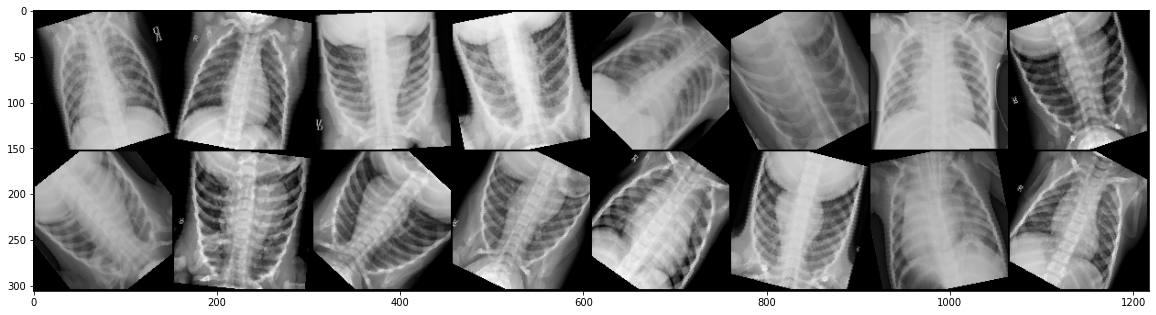

In [13]:
plt.figure(figsize=(20,30))

dataiter = iter(train_dl)
images, labels = dataiter.next()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

# Model 🧠

In [14]:
class CNN(nn.Module):
    def __init__(self, input_channels, n_classes):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, 4096),
			nn.ReLU(),
			nn.Dropout(.5),
			nn.Linear(4096, 4096),
			nn.ReLU(),
			nn.Dropout(.5),
			nn.Linear(4096, n_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

model = CNN(input_channels=1, n_classes=3).to(device)

In [15]:
# check dimensions
model.conv_layers(images[:1].to(device)).size()

torch.Size([1, 128, 5, 5])

In [16]:
summary(model, (1, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 148, 148]             160
              ReLU-2         [-1, 16, 148, 148]               0
       BatchNorm2d-3         [-1, 16, 148, 148]              32
            Conv2d-4         [-1, 16, 146, 146]           2,320
              ReLU-5         [-1, 16, 146, 146]               0
       BatchNorm2d-6         [-1, 16, 146, 146]              32
         MaxPool2d-7           [-1, 16, 73, 73]               0
            Conv2d-8           [-1, 32, 71, 71]           4,640
              ReLU-9           [-1, 32, 71, 71]               0
      BatchNorm2d-10           [-1, 32, 71, 71]              64
           Conv2d-11           [-1, 32, 69, 69]           9,248
             ReLU-12           [-1, 32, 69, 69]               0
      BatchNorm2d-13           [-1, 32, 69, 69]              64
        MaxPool2d-14           [-1, 32,

# Train 🏋️‍♀️

## Validation Metrics 📝

In [17]:
def val(data_dl, model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_dl:
            images = images.to(device)
            outputs = model(images)
            for out, label in zip(outputs, labels):
                if torch.argmax(out) == torch.argmax(label):
                    correct += 1
                
            total += len(outputs)
        acc = correct/total
        return acc
print(val(test_dl, model))

0.3333333333333333


## Training 💪

In [18]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

0it [00:00, ?it/s]

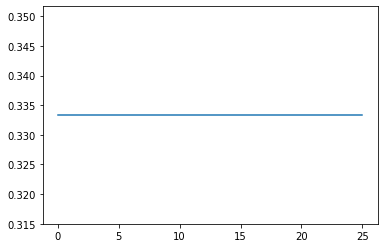


### EPOCH: 1, MeanLoss: 0.6377184028808888, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

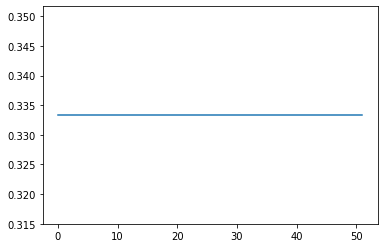


### EPOCH: 2, MeanLoss: 0.6367732288745733, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

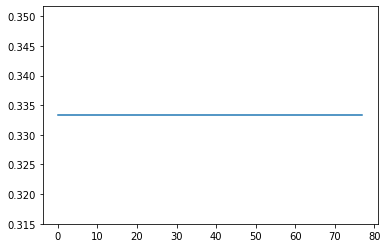


### EPOCH: 3, MeanLoss: 0.6366519458018817, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

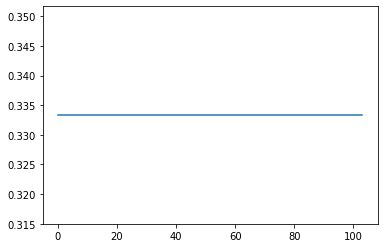


### EPOCH: 4, MeanLoss: 0.636602797645789, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

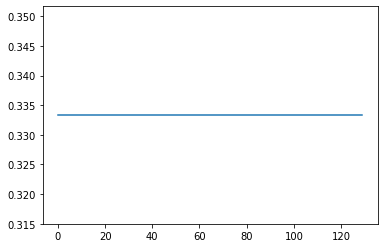


### EPOCH: 5, MeanLoss: 0.636611113181481, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

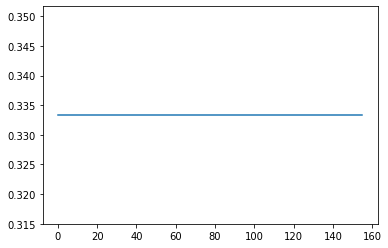


### EPOCH: 6, MeanLoss: 0.6365890486882283, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

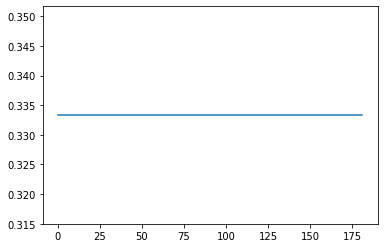


### EPOCH: 7, MeanLoss: 0.6365620835469319, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

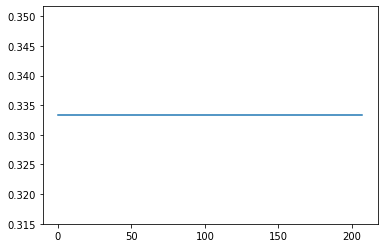


### EPOCH: 8, MeanLoss: 0.6365644457248542, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

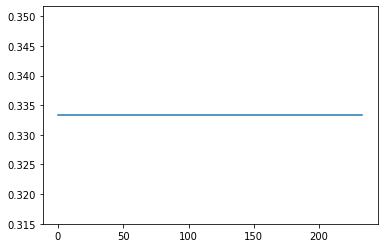


### EPOCH: 9, MeanLoss: 0.6365529067241229, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

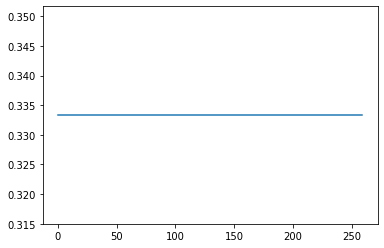


### EPOCH: 10, MeanLoss: 0.6365521960533582, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

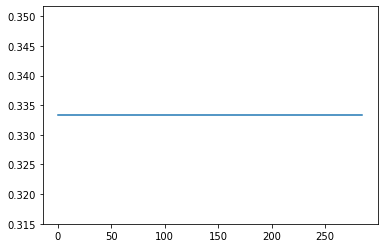


### EPOCH: 11, MeanLoss: 0.6365349579315919, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

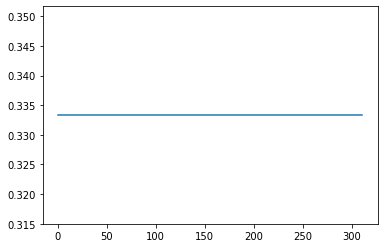


### EPOCH: 12, MeanLoss: 0.6365184648678853, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

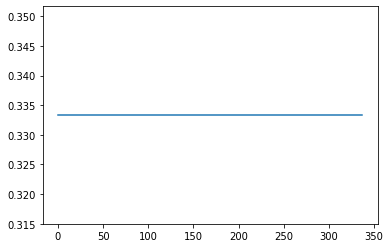


### EPOCH: 13, MeanLoss: 0.6365190157523521, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

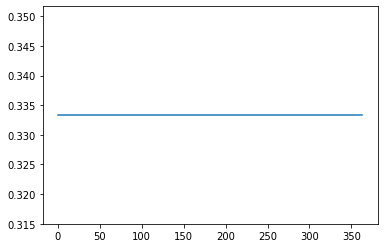


### EPOCH: 14, MeanLoss: 0.6365171106962058, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

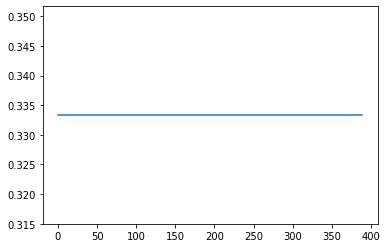


### EPOCH: 15, MeanLoss: 0.6365185095713689, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

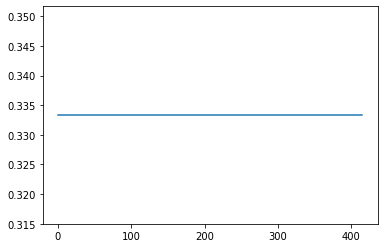


### EPOCH: 16, MeanLoss: 0.6365151254030375, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

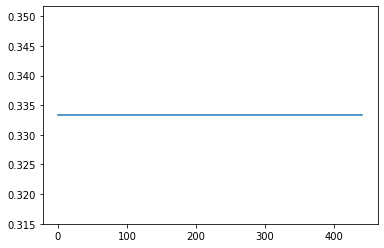


### EPOCH: 17, MeanLoss: 0.6365160850378183, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

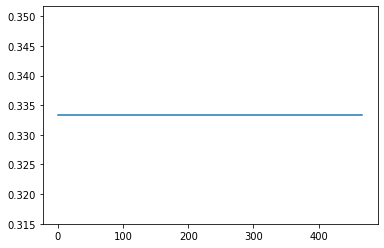


### EPOCH: 18, MeanLoss: 0.6365152734976548, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

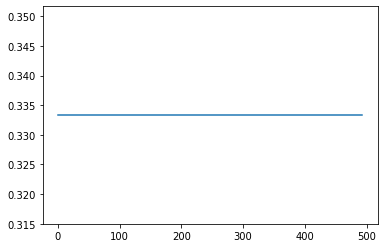


### EPOCH: 19, MeanLoss: 0.6365151409919445, Test Acc: 0.3333333333333333




0it [00:00, ?it/s]

In [ ]:
EPOCHS = 32
test_accs = []
losses = []
max_acc = 0

for epoch in range(EPOCHS):
    losses_sh = []
    for i, (images, labels) in tqdm(enumerate(train_dl)):
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        nn.functional.one_hot(preds.argmax(1), 3)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        losses.append(loss.item())
        losses_sh.append(loss.item())

        if i%10 == 0:
            test_acc = val(test_dl, model)
            test_accs.append(test_acc)
            if test_acc >= .90 and test_acc > max_acc and loss.item() < 0.1:
                max_acc = test_acc
                model.cpu()
                print('\ntest acc', test_acc, ' loss: ', loss.item(), ' saving model...')
                torch.save(model, f"drive/MyDrive/AI/Projects/{test_acc}_loss{loss.item():.3f}.pt")
                model.cuda()

    mean_loss = sum(losses_sh)/len(losses_sh)
    scheduler.step(mean_loss)

    test_acc = val(test_dl, model)
    plt.plot(test_accs)
    plt.show()

    print(f"\n### EPOCH: {epoch+1}, MeanLoss: {mean_loss}, Test Acc: {test_acc}\n\n")

# Testing 📊

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
# Load Model
model = torch.load('drive/MyDrive/AI/Projects/xray_model.pt')
model.eval()

In [ ]:
def get_all_preds_labels(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        preds = preds.argmax(1)
        
        labels = labels.argmax(1)

        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

    return all_preds, all_labels

In [ ]:
def plt_confusion_matrix(model, dataloader):
    with torch.no_grad():
        test_preds, test_labels = get_all_preds_labels(model, dataloader)

    cf = confusion_matrix(np.array(test_labels), np.array(test_preds))

    df_cm = pd.DataFrame(cf, index = [i for i in ['BAC', 'N', 'VIR']],
                    columns = [i for i in ['BAC', 'N', 'VIR']])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True)

    ax.set(xlabel='True Label', ylabel='Pred Label')
    plt.show()

In [ ]:
plt_confusion_matrix(model, test_dl)